# Reverse-engineer toy checkpoints

The purpose of this notebook is to reverse engineer the two weird toy models we found and their corresponding phase transitions.

**Loss curves** 
1. morning-donkey-180: https://wandb.ai/perceptual-alignment/induction_test/runs/0diekj2x?workspace=user-praneetquantumx
2. silver-jazz-185: https://wandb.ai/perceptual-alignment/induction_test/runs/g5tfugyy?workspace=user-praneetquantumx 

Things to do:
1. Plot weight norms
2. Line up weight norms with loss

I'll also replicate the results with the corrected loss function and adding noise to the background.

In [1]:
from dataclasses import dataclass
from vit_prisma.models.layers.transformer_block import TransformerBlock
import torch.nn as nn
import torch
import pandas as pd

import wandb

from huggingface_hub import hf_hub_download
import torch
from vit_prisma.models.base_vit import BaseViT
from vit_prisma.configs.DSpritesConfig import GlobalConfig
from vit_prisma.utils.wandb_utils import update_dataclass_from_dict
from ImagenetConfig import GlobalConfig

from huggingface_hub import HfApi

import csv
import os



In [2]:
TOTAL_DICTIONARY = {
    "ImageNet-Tiny-AttentionOnly": {
        'run_id': 'cbmxclie',
        'transformer_config': {
            'attention_only': True,
            'hidden_dim': 768,
            'num_heads': 12,
            'num_layers': 1,
        }
    },
    "ImageNet-Tiny-Attention-and-MLP": {
        'run_id': '5t8v4pzy',
        'transformer_config': {
            'attention_only': False,
            'hidden_dim': 768,
            'num_heads': 12,
            'num_layers': 1
        }
    },
    "ImageNet-Base-AttentionOnly": {
        'run_id': 'gq8hsa6g',
        'transformer_config': {
            'attention_only': True,
            'hidden_dim': 768,
            'num_heads': 12,
            'num_layers': 2
        }
    },
    "ImageNet-Base-Attention-and-MLP": {
        'run_id': 'nj50l0e5',
        'transformer_config': {
            'attention_only': False,
            'hidden_dim': 768,
            'num_heads': 12,
            'num_layers': 2
        }
    },
    "ImageNet-Small-AttentionOnly": {
        'run_id': 'pxghu42f',
        'transformer_config': {
            'attention_only': True,
            'hidden_dim': 768,
            'num_heads': 12,
            'num_layers': 3
        }
    },
    "ImageNet-Small-Attention-and-MLP": {
        'run_id': 'jq1hm27e',
        'transformer_config': {
            'attention_only': False,
            'hidden_dim': 768,
            'num_heads': 12,
            'num_layers': 3
        }
    },
    "ImageNet-Medium-Attention-and-MLP": {
        'run_id': '09hc5115',
        'transformer_config': {
            'attention_only': False,
            'hidden_dim': 768,
            'num_heads': 12,
            'num_layers': 4,
        }
    },
    "ImageNet-Medium-AttentionOnly": {
        'run_id': '7f5221tt',
        'transformer_config': {
            'attention_only': True,
            'hidden_dim': 768,
            'num_heads': 12,
            'num_layers': 4
        }
    }
}


In [3]:

def get_checkpoint_info(model_repo: str):
    """
    Get the titles of files and the number of checkpoints from a Hugging Face model repository.

    Args:
    model_repo (str): The name of the model repository on Hugging Face.

    Returns:
    Tuple[List[str], int]: A tuple containing a list of file titles and the number of checkpoints.
    """
    api = HfApi()
    model_files = api.list_repo_files(model_repo)
    
    # Assuming each checkpoint has a distinct pattern, like 'checkpoint-XXXX/'
    checkpoint_files = [f for f in model_files if f.startswith("checkpoint")]

    return model_files, len(checkpoint_files)




In [5]:



# REPO_ID = "IamYash/dSprites-tiny-AttentionOnly"
# FILENAME = "model_0.pth"

def fix_state_dict(state_dict):
    """
    Fixes the state dictionary by removing the 'module.' prefix from each key.
    This is useful when loading a state dictionary saved from a DataParallel
    model into a non-DataParallel model.
    
    Args:
        state_dict (dict): The state dictionary with 'module.' prefix in keys.

    Returns:
        dict: The fixed state dictionary with the prefix removed from its keys.
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k[7:] if k.startswith('module.') else k  # remove `module.` prefix
        new_state_dict[name] = v
    return new_state_dict

def load_huggingface_model(checkpoint_num, REPO_ID, transformer_config):

    # REPO_ID = "IamYash/ImageNet-Tiny-AttentionOnly"
    FILENAME = f"checkpoint_{checkpoint_num}.pth"

    checkpoint = torch.load(
    hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
    )

    config = GlobalConfig()
    # print(config)
    update_dict = {
        'transformer': transformer_config
    }
    update_dataclass_from_dict(config, update_dict)

    model = BaseViT(config)
    model.load_state_dict(fix_state_dict(checkpoint['model_state_dict']))
    return model 



In [7]:
# Assuming the MLP layers are defined within the TransformerBlock in your model as 'mlp'
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to compute norms for each neuron in a fully connected layer
def compute_neuron_norms(name, fc_layer):
    if hasattr(fc_layer, 'weight'):
        # Extract the weight matrix
        weight_matrix = fc_layer.weight.data
        # Compute L2 norm for each neuron (each row in the weight matrix)
        if name == 'blocks.0.attention.qkv':
            # Get individual heads
            weight_matrix = weight_matrix.reshape(12, 3, 64, 768)

            neuron_norms = []
            # Calculate the norm for each head
            for i in range(12):  # Loop over each head
                # Extract the weights for the i-th head across Q, K, and V
                head_weights = weight_matrix[i,:, :, :] 

                # Compute the L2 norm across both head dimensions and feature dimensions
                norm = torch.norm(head_weights, p=2) 
                print(norm.shape)
                neuron_norms.append(norm.item())
        
        else:
            neuron_norms = torch.norm(weight_matrix, dim=1, p=2)

        # Compute standard deviation of the norms
        # std_of_norms = torch.std(neuron_norms)

            neuron_norms = torch.norm(weight_matrix)

        return neuron_norms # Return empty tensor if no weights

# Collect neuron norms for each MLP layer
def other_layer_norms(model):
    all_mean_norms = defaultdict(list)
    all_std_norms = defaultdict(list)
    for module_name, module in model.named_modules():
        # if isinstance(module, torch.nn.Linear):  # Assuming MLP layers are Linear layers
        #     print('yes')
        neuron_norms = compute_neuron_norms(module_name, module)
        if neuron_norms: # If the layer has neurons
            all_mean_norms[module_name] = neuron_norms
            # all_std_norms[module_name] = std_norms
    return all_mean_norms, all_std_norms



In [8]:
# Compute the L2 norm for each position embedding vector
def get_position_embedding_norms(model):
    position_embeddings = model.position_embedding.cpu().detach()
    # print(position_embeddings.shape)
    position_embedding_norms = torch.norm(position_embeddings, dim=-1)

    return position_embedding_norms

def get_patch_embedding_norms(model):
    patch_embeddings = model.patch_embedding.proj.weight
    weight_norm = torch.norm(patch_embeddings)
    return weight_norm

In [11]:
def get_per_head_qkv_l2_norms(model, block_index=0):
    # Access the specific transformer block
    transformer_block = dict(model.named_modules())[f'blocks.{block_index}']
    multi_head_attention = transformer_block.attention

    # Extract the linear layers for Q, K, V
    qkv_weight = multi_head_attention.qkv.weight  # Assuming a combined QKV linear layer
    qkv_bias = multi_head_attention.qkv.bias if multi_head_attention.qkv.bias is not None else None

    # Reshape and split for per-head QKV
    num_heads = model.config.transformer.num_heads
    head_dim = qkv_weight.size(1) // num_heads

    qkv_weight = qkv_weight.view(3, num_heads, head_dim, -1)
    
    # Handle the case where bias is None
    if qkv_bias is not None:
        qkv_bias = qkv_bias.view(3, num_heads, head_dim)

    q_weight, k_weight, v_weight = qkv_weight.chunk(3, dim=0)

    # Initialize lists to store norms
    q_weight_norms, k_weight_norms, v_weight_norms = [], [], []
    q_bias_norms, k_bias_norms, v_bias_norms = [], [], []

    # Calculate L2 norms for each head
    for head in range(num_heads):
        q_weight_norms.append(torch.norm(q_weight[:, head], p=2))
        k_weight_norms.append(torch.norm(k_weight[:, head], p=2))
        v_weight_norms.append(torch.norm(v_weight[:, head], p=2))

        if qkv_bias is not None:
            q_bias, k_bias, v_bias = qkv_bias.chunk(3, dim=0)
            q_bias_norms.append(torch.norm(q_bias[:, head], p=2))
            k_bias_norms.append(torch.norm(k_bias[:, head], p=2))
            v_bias_norms.append(torch.norm(v_bias[:, head], p=2))
        else:
            q_bias_norms.append(0)
            k_bias_norms.append(0)
            v_bias_norms.append(0)

    # Convert the lists of norms to NumPy arrays
    q_weight_norms_np = torch.stack(q_weight_norms).detach().numpy()
    k_weight_norms_np = torch.stack(k_weight_norms).detach().numpy()
    v_weight_norms_np = torch.stack(v_weight_norms).detach().numpy()
    q_bias_norms_np = torch.tensor(q_bias_norms).detach().numpy()  # Using torch.tensor since biases might be zeros
    k_bias_norms_np = torch.tensor(k_bias_norms).detach().numpy()
    v_bias_norms_np = torch.tensor(v_bias_norms).detach().numpy()

    return q_weight_norms_np, k_weight_norms_np, v_weight_norms_np, q_bias_norms_np, k_bias_norms_np, v_bias_norms_np

# # Usage
# model = load_huggingface_model(0, 'IamYash/ImageNet-Tiny-AttentionOnly', TOTAL_DICTIONARY['ImageNet-Tiny-AttentionOnly']['transformer_config'])
# q_weight_norms, k_weight_norms, v_weight_norms, q_bias_norms, k_bias_norms, v_bias_norms = get_per_head_qkv_l2_norms(model)

# plt.figure(figsize=(10, 6))
# plt.plot(q_weight_norms, marker='o', label='Q')

# Check position embeddings l2

In [12]:
def create_loss(name, run_name):

    # if file exists, don't create
    if os.path.exists(os.path.join('loss_curves', f'{name}.csv')):
        print("File already exists.")
        return
    
    wandb.login()

    # Replace 'username', 'project', and 'run_id' with your details
    api = wandb.Api()
    run = api.run(f"vit-prisma/Imagenet/{run_name}")

    # Fetch loss history
    # Replace 'loss' with the exact metric name you used in your training script
    history = run.history(keys=['Val Loss'])
    # print(history)

    # Write to CSV
    with open(os.path.join('loss_curves', f'{name}.csv'), 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Step", "Loss"])
        for row in history.iterrows():
            step, data = row
            loss = data['Val Loss']
            writer.writerow([step, loss])

    print("CSV file created.")


In [13]:
# Load and plot loss curve csv file

def plot_pos(loss_curve_file_name, title, pos_norms):
    num_checkpoints= pos_norms.shape[-1]

    test_df = pd.read_csv(loss_curve_file_name)

    # Creating figure and axis objects with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plotting the loss curve
    ax1.plot(range(num_checkpoints), test_df["Loss"], label="Test Loss")

    ax1.set_xlabel('Checkpoint')

    ax1.tick_params(axis='x', labelsize=6)  # Making x-axis labels smaller

    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')
    # ax1.set_xticks(checkpoint_numbers)  # Setting x-ticks to actual step values
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))  # Format as integers


    ax1.plot([], [], color='r', label='Per-patch position emb norms')

    # plt legend
    ax1.legend(loc='upper right')

    # Creating a second y-axis for patch_norms
    ax2 = ax1.twinx()

    # Limit x axis
    ax1.set_xlim(0, 20)

    # Plot patches

    for i in range(pos_norms.shape[0]):
        # make line very skinny
        ax2.plot(range(num_checkpoints), pos_norms[i, :], linewidth=.5, color='r', alpha=0.86)
        # ax2.plot(checkpoint_numbers, patch_norms[i, :], label=f'Position {i+1}', color='r')
        # ax2.scatter(checkpoint_numbers, patch_norms[i, :], label=f'Position {i+1}')
    ax2.set_ylabel('Patch Norms', color='r')
    ax2.tick_params('y', colors='r')

    plt.title(f"Loss Curves and Per-Patch Position Embedding L2 Norms for {title}")
    fig.tight_layout()
    plt.show()
    return fig 



In [14]:
# Load and plot loss curve csv file

def plot_patch(loss_curve_file_name, title, pos_norms):
    num_checkpoints= len(pos_norms)

    test_df = pd.read_csv(loss_curve_file_name)

    # Creating figure and axis objects with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plotting the loss curve
    ax1.plot(range(num_checkpoints), test_df["Loss"], label="Test Loss")

    ax1.set_xlabel('Checkpoint')

    ax1.tick_params(axis='x', labelsize=6)  # Making x-axis labels smaller

    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')
    # ax1.set_xticks(checkpoint_numbers)  # Setting x-ticks to actual step values
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))  # Format as integers


    ax1.plot([], [], color='r', label='Patch norm')

    # plt legend
    ax1.legend(loc='upper right')

        ax1.set_xlim(0, 20)


    # Creating a second y-axis for patch_norms
    ax2 = ax1.twinx()

    # Plot patches
    ax2.plot(range(num_checkpoints), pos_norms, linewidth=.5, color='r', alpha=0.86)


    ax2.set_ylabel('Patch Norms', color='r')
    ax2.tick_params('y', colors='r')

    plt.title(f"Loss Curves and Patch Embedding L2 Norm for {title}")
    fig.tight_layout()
    plt.show()
    return fig 



IndentationError: unexpected indent (1239272731.py, line 29)

In [15]:
# def plot_all_other(loss_curve_file_name, title, all_other_norms):

#     layers = ['blocks.0.attention.qkv', 'blocks.0.attention.proj', 'head']
#     norms = {layer: [] for layer in layers}

#     num_checkpoints = len(all_other_norms)

#     for checkpoint in all_other_norms:
#         for layer in layers:
#             if layer != 'blocks.0.attention.qkv':
#                 norms[layer].append(checkpoint[layer])
#             else:
#                 norms[layer + str(i)].append(checkpoint[layer][i])

#     # Custom colors for each layer
#     colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray']
#     color_iter = iter(colors)

#     # Creating figure and axis objects with two y-axes
#     fig, ax1 = plt.subplots(figsize=(10, 6))

#     df = pd.read_csv(loss_curve_file_name)

#     # Plotting the loss curve
#     ax1.plot(range(num_checkpoints), df['Loss'], label="Test Loss", color=next(color_iter))

#     ax1.set_xlabel('Checkpoint')
#     ax1.tick_params(axis='x', labelsize=6)
#     ax1.set_ylabel('Loss', color='b')
#     ax1.tick_params('y', colors='b')
#     ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))

#     # Creating a second y-axis for layer norms
#     ax2 = ax1.twinx()

#     # Plotting each layer with a different color
#     for layer, values in norms.items():
#         # if not qkv
#         if layer != 'blocks.0.attention.qkv':
#             ax2.plot(range(num_checkpoints), values, label=layer, linewidth=1, alpha=0.86, color=next(color_iter))
#         else:
#             for i in range(12):
#                 ax2.plot(range(num_checkpoints), values[i], label=layer, linewidth=1, alpha=0.86, color=next(color_iter))

#     ax2.set_ylabel('Layer Norms', color='r')
#     ax2.tick_params('y', colors='r')

#     # Combine legends from both axes
#     lines, labels = ax1.get_legend_handles_labels()
#     lines2, labels2 = ax2.get_legend_handles_labels()
#     ax2.legend(lines + lines2, labels + labels2, loc='upper right')

#     plt.title(f"Loss Curve and Layer L2 Norms for {title}")
#     fig.tight_layout()
#     plt.show()


import matplotlib.pyplot as plt
import pandas as pd

def plot_all_other(loss_curve_file_name, title, all_other_norms):
    # Read the loss curve file
    df = pd.read_csv(loss_curve_file_name)

    num_checkpoints = len(all_other_norms)
    checkpoints = range(num_checkpoints)

    # Initialize plots
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plotting the loss curve
    ax1.plot(checkpoints, df['Loss'], label="Test Loss", color='b')
    ax1.set_xlabel('Checkpoint')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')

    # Creating a second y-axis for layer norms
    ax2 = ax1.twinx()

    # Iterate over checkpoints and plot norms for each head in the QKV layer
    for head_idx in range(12):
        head_norms = [all_other_norms[ckpt]['blocks.0.attention.qkv'][head_idx] for ckpt in checkpoints]
        ax2.plot(checkpoints, head_norms, label=f'Head {head_idx}', linewidth=1, alpha=0.86)

    ax2.set_ylabel('Head Norms', color='r')
    ax2.tick_params('y', colors='r')

    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    # Limit
    ax1.set_xlim(0, 20)

    plt.title(f"Loss Curve and Attention Head Norms for {title}")
    fig.tight_layout()
    plt.show()


In [16]:
for k in TOTAL_DICTIONARY.keys():
    print(k)

ImageNet-Tiny-AttentionOnly
ImageNet-Tiny-Attention-and-MLP
ImageNet-Base-AttentionOnly
ImageNet-Base-Attention-and-MLP
ImageNet-Small-AttentionOnly
ImageNet-Small-Attention-and-MLP
ImageNet-Medium-Attention-and-MLP
ImageNet-Medium-AttentionOnly


In [17]:
def plot_qkv_weights(qkv_weight_norms, repo_name):
    num_checkpoints = len(qkv_weight_norms)

    # Prepare data for plotting
    q_weight_data = [qkv_weight_norms[i][0] for i in range(num_checkpoints)]
    k_weight_data = [qkv_weight_norms[i][1] for i in range(num_checkpoints)]
    v_weight_data = [qkv_weight_norms[i][2] for i in range(num_checkpoints)]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_checkpoints), q_weight_data, label='Q Weights', marker='o', color='blue')
    plt.plot(range(num_checkpoints), k_weight_data, label='K Weights', marker='^', color='red')
    plt.plot(range(num_checkpoints), v_weight_data, label='V Weights', marker='s', color='green')

    plt.xlabel('Checkpoint')
    plt.ylabel('L2 Norm')
    plt.title(f'QKV Weights Norms Evolution for {repo_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_qkv_biases(qkv_bias_norms, repo_name):
    num_checkpoints = len(qkv_bias_norms)

    # Prepare data for plotting
    q_bias_data = [qkv_bias_norms[i][0] for i in range(num_checkpoints)]
    k_bias_data = [qkv_bias_norms[i][1] for i in range(num_checkpoints)]
    v_bias_data = [qkv_bias_norms[i][2] for i in range(num_checkpoints)]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_checkpoints), q_bias_data, label='Q Biases', marker='o', linestyle='dashed', color='blue')
    plt.plot(range(num_checkpoints), k_bias_data, label='K Biases', marker='^', linestyle='dashed', color='red')
    plt.plot(range(num_checkpoints), v_bias_data, label='V Biases', marker='s', linestyle='dashed', color='green')

    plt.xlabel('Checkpoint')
    plt.ylabel('L2 Norm')
    plt.title(f'QKV Biases Norms Evolution for {repo_name}')
    plt.legend()
    plt.grid(True)
    plt.show()



In [18]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plotly_patch_with_qkv(loss_curve_file_name, title, qkv_weight_norms, qkv_bias_norms, qkv_norms_yrange=[10,35]):
    num_checkpoints = len(qkv_weight_norms)

    test_df = pd.read_csv(loss_curve_file_name)

    # Create subplot with 2 y-axes
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add the loss curve
    fig.add_trace(
        go.Scatter(x=list(range(num_checkpoints)), y=test_df["Loss"], name="Test Loss", line=dict(color='blue')),
        secondary_y=False,
    )

    # Assuming there are 12 heads, iterate over each head for Q, K, V weights and biases
    num_heads = 12  # Adjust this according to the actual number of heads
    for i in range(num_heads):
        # Add traces for QKV weights for each head
        fig.add_trace(
            go.Scatter(x=list(range(num_checkpoints)), y=[norms[0][i] for norms in qkv_weight_norms], 
                       name=f'Head {i+1} Q Weight', line=dict(color='red')),
            secondary_y=True,
        )
        fig.add_trace(
            go.Scatter(x=list(range(num_checkpoints)), y=[norms[1][i] for norms in qkv_weight_norms], 
                       name=f'Head {i+1} K Weight', line=dict(color='green')),
            secondary_y=True,
        )
        fig.add_trace(
            go.Scatter(x=list(range(num_checkpoints)), y=[norms[2][i] for norms in qkv_weight_norms], 
                       name=f'Head {i+1} V Weight', line=dict(color='purple')),
            secondary_y=True,
        )

        # Add traces for QKV biases for each head
        fig.add_trace(
            go.Scatter(x=list(range(num_checkpoints)), y=[norms[0][i] for norms in qkv_bias_norms], 
                       name=f'Head {i+1} Q Bias', line=dict(color='red', dash='dash')),
            secondary_y=True,
        )
        fig.add_trace(
            go.Scatter(x=list(range(num_checkpoints)), y=[norms[1][i] for norms in qkv_bias_norms], 
                       name=f'Head {i+1} K Bias', line=dict(color='green', dash='dash')),
            secondary_y=True,
        )
        fig.add_trace(
            go.Scatter(x=list(range(num_checkpoints)), y=[norms[2][i] for norms in qkv_bias_norms], 
                       name=f'Head {i+1} V Bias', line=dict(color='purple', dash='dash')),
            secondary_y=True,
        )

    # Set x-axis title
    fig.update_xaxes(title_text="Checkpoint")


    # Set y-axes titles
    fig.update_yaxes(title_text="Test Loss", secondary_y=False)

    if qkv_norms_yrange:
        # Manually set the range for the secondary y-axis
        fig.update_yaxes(title_text="QKV Norms", range=qkv_norms_yrange, secondary_y=True)
    else:
        fig.update_yaxes(title_text="QKV Norms", secondary_y=True)

    # Add figure title
    fig.update_layout(title_text=f"Loss Curves and QKV Norms for {title}")

    fig.show()



In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def matplotlib_patch_with_qkv(loss_curve_file_name, title, qkv_weight_norms, qkv_bias_norms, qkv_norms_yscale='linear'):
    num_checkpoints = len(qkv_weight_norms)

    test_df = pd.read_csv(loss_curve_file_name)

    # Create figure and axis for the loss curve
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plotting the loss curve
    ax1.plot(test_df.index, test_df["Loss"], label="Test Loss", color='blue')
    ax1.set_xlabel('Checkpoint')
    ax1.set_ylabel('Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title(f"Loss Curves and QKV Norms for {title}")

    # Creating a second y-axis for QKV norms
    ax2 = ax1.twinx()
    ax2.set_ylabel('QKV Norms', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_yscale(qkv_norms_yscale)

    # Define colors for Q, K, and V components
    colors = {'Q': 'red', 'K': 'green', 'V': 'purple'}

    # Add plots for QKV weights and biases
    num_heads = len(qkv_weight_norms[0][0])  # Assuming the first element of qkv_weight_norms has the right shape
    for i in range(num_heads):
        # Q, K, and V weights for each head
        ax2.plot(test_df.index, [norms[0][i] for norms in qkv_weight_norms], color=colors['Q'], alpha=0.5)
        ax2.plot(test_df.index, [norms[1][i] for norms in qkv_weight_norms], color=colors['K'], alpha=0.5)
        ax2.plot(test_df.index, [norms[2][i] for norms in qkv_weight_norms], color=colors['V'], alpha=0.5)

    # Plot dummy lines for legend
    for component, color in colors.items():
        ax2.plot([], [], label=component, color=color)

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

# Example usage
# matplotlib_patch_with_qkv('loss_curve_file.csv', 'My Model', qkv_weight_norms, qkv_bias_norms, qkv_norms_yscale='log')


In [213]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plotly_patch_with_qkv(loss_curve_file_name, title, qkv_weight_norms, qkv_bias_norms):
    num_checkpoints = len(qkv_weight_norms)

    test_df = pd.read_csv(loss_curve_file_name)

    # Create subplot with 2 y-axes, adjusting figure dimensions
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.update_layout(width=800, height=600)  # Adjust width and height as needed

    # Add the loss curve
    fig.add_trace(
        go.Scatter(x=test_df.index, y=test_df["Loss"], name="Test Loss", line=dict(color='blue')),
        secondary_y=False,
    )

    # Define colors for Q, K, and V components
    colors = {'Q': 'red', 'K': 'green', 'V': 'purple'}

    # Add plots for QKV weights and biases
    num_heads = len(qkv_weight_norms[0][0])
    for i in range(num_heads):
        for component in ['Q', 'K', 'V']:
            fig.add_trace(
                go.Scatter(x=test_df.index, y=[norms[{'Q': 0, 'K': 1, 'V': 2}[component]][i] for norms in qkv_weight_norms], 
                           name=f'{component} Head {i+1}', line=dict(color=colors[component]),
                           showlegend=False),  # Hiding individual traces from legend
                secondary_y=True,
            )

    # Add dummy traces for legend
    for component, color in colors.items():
        fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', name=component, line=dict(color=color)), secondary_y=True)

    # Set x-axis title
    fig.update_xaxes(title_text="Checkpoint")

    # Set y-axes titles
    fig.update_yaxes(title_text="Test Loss", secondary_y=False)
    fig.update_yaxes(title_text="QKV Norms", secondary_y=True)

    # Add figure title
    fig.update_layout(title_text=f"Loss Curves and QKV Norms for {title}")

    fig.show()

# Example usage
# plotly_patch_with_qkv('loss_curve_file.csv', 'My Model', qkv_weight_norms, qkv_bias_norms)


In [218]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px  # Import for color sequences

def plotly_combined_qkv_norms(loss_curve_file_name, title, qkv_weight_norms, qkv_bias_norms):
    num_checkpoints = len(qkv_weight_norms)
    num_heads = len(qkv_weight_norms[0][0])

    test_df = pd.read_csv(loss_curve_file_name)

    # Calculate combined norms for each head
    combined_norms = np.zeros((num_heads, num_checkpoints))
    for c in range(num_checkpoints):
        for head in range(num_heads):
            combined_norm = np.sqrt(qkv_weight_norms[c][0][head]**2 + qkv_weight_norms[c][1][head]**2 + qkv_weight_norms[c][2][head]**2)
            combined_norms[head, c] = combined_norm

    # Create subplot with 2 y-axes, adjusting figure dimensions
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.update_layout(width=800, height=600)

    # Add the loss curve
    fig.add_trace(
        go.Scatter(x=test_df.index, y=test_df["Loss"], name="Test Loss", line=dict(color='blue')),
        secondary_y=False,
    )

    # Add plots for combined QKV norms
    color_sequence = px.colors.qualitative.Plotly  # Access color sequence
    for head in range(num_heads):
        fig.add_trace(
            go.Scatter(x=list(range(num_checkpoints)), y=combined_norms[head], 
                       name=f'Head {head + 1}', line=dict(color=color_sequence[head % len(color_sequence)])),
            secondary_y=True,
        )

    # Set x-axis title
    fig.update_xaxes(title_text="Checkpoint")

    # Set y-axes titles
    fig.update_yaxes(title_text="Test Loss", secondary_y=False)
    fig.update_yaxes(title_text="Combined QKV Norms", secondary_y=True)

    # Add figure title
    fig.update_layout(title_text=f"Loss Curves and Combined QKV Norms for {title}")

    fig.show()

# Example usage
# plotly_combined_qkv_norms('loss_curve_file.csv', 'My Model', qkv_weight_norms, qkv_bias_norms)


File already exists.


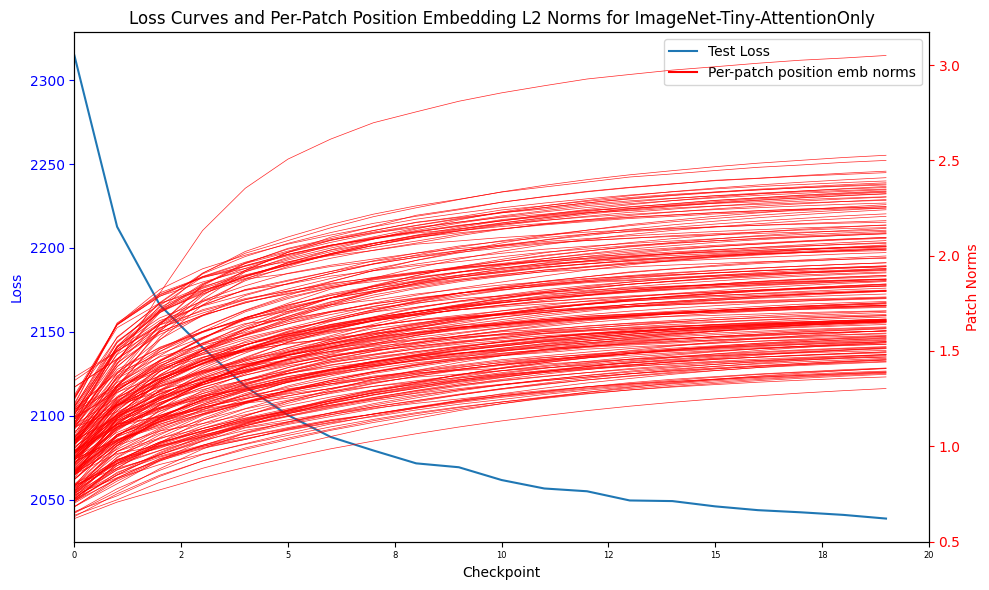

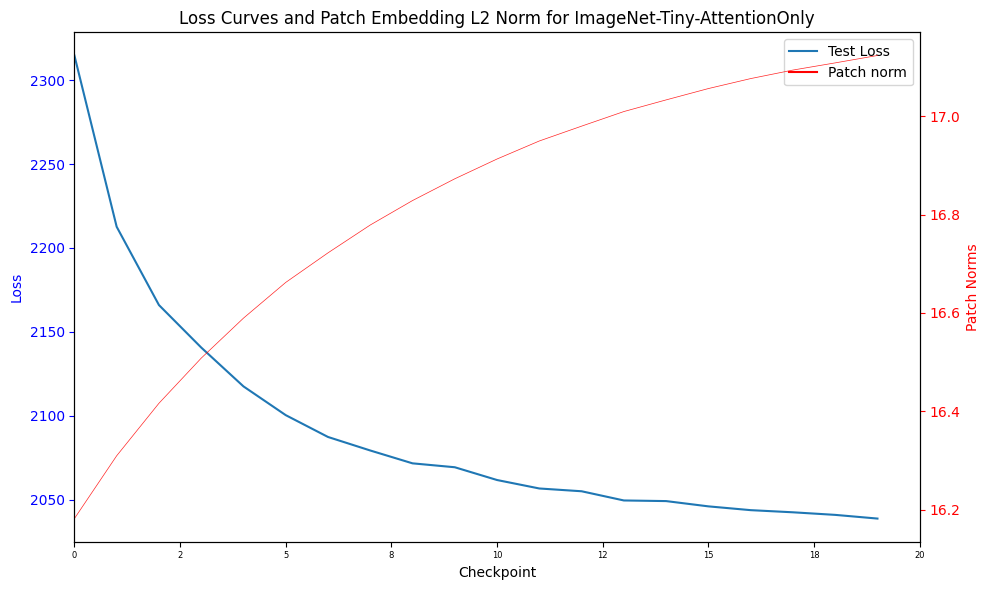

File already exists.


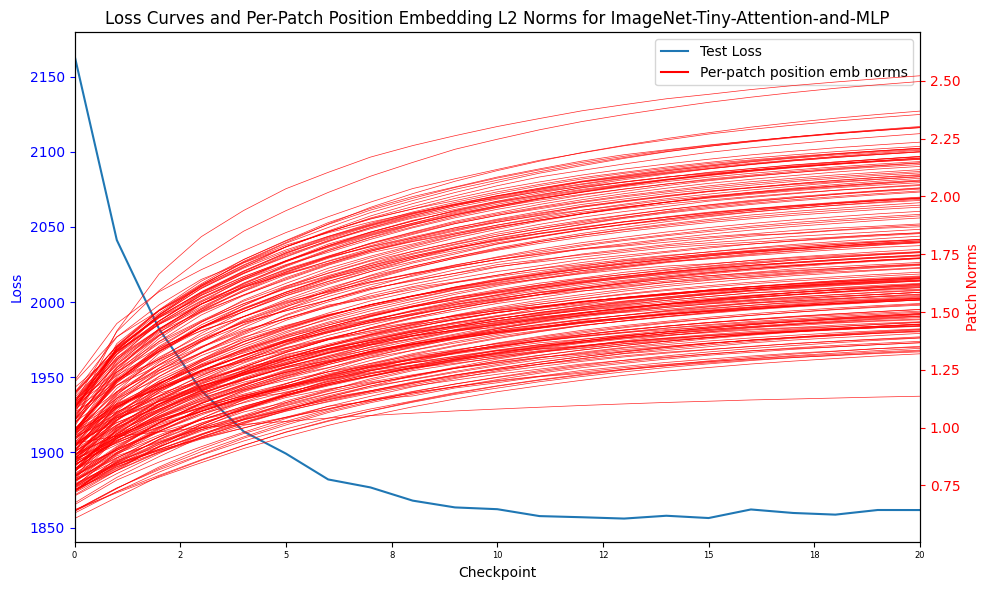

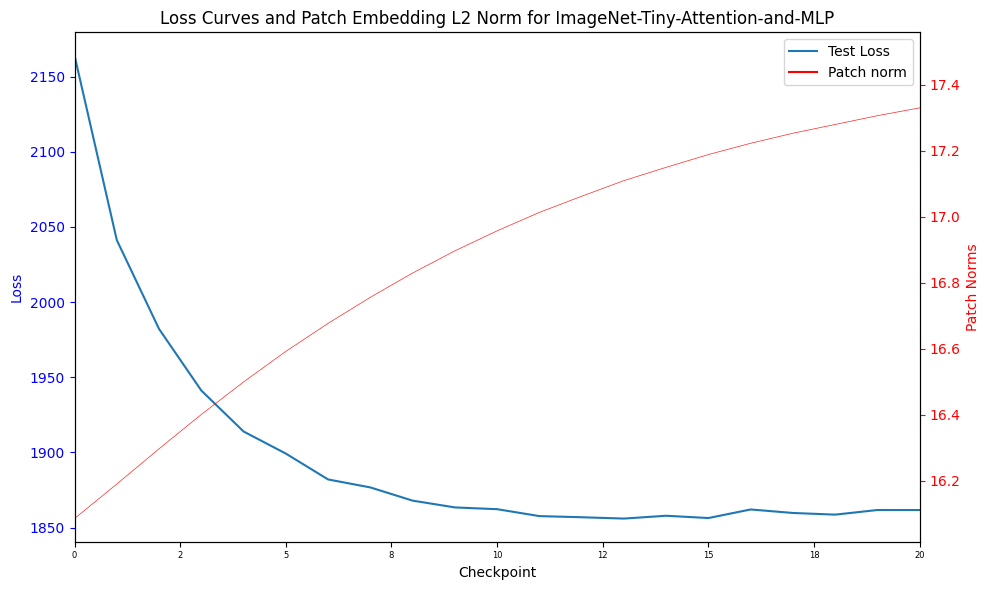

File already exists.


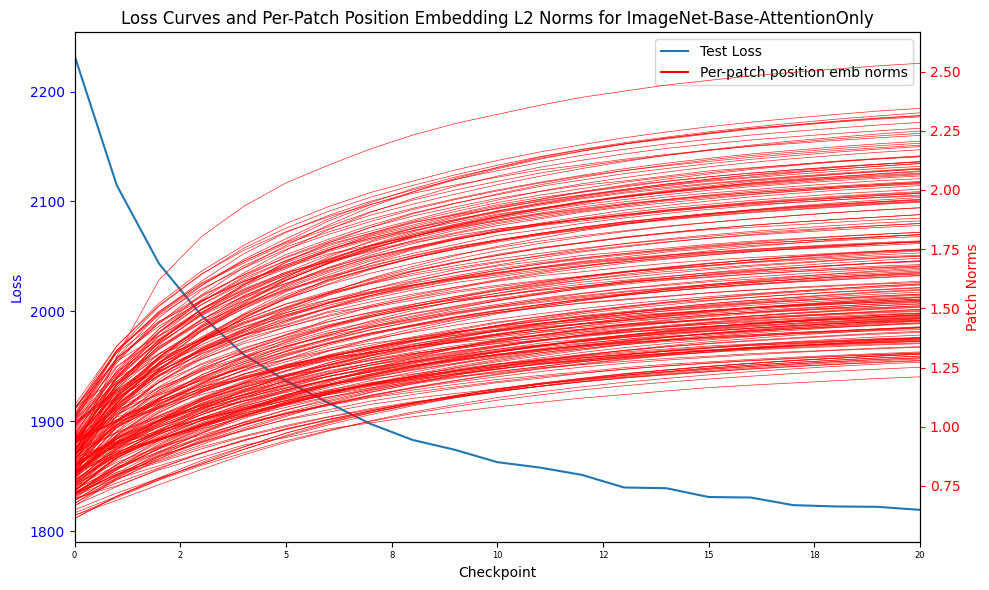

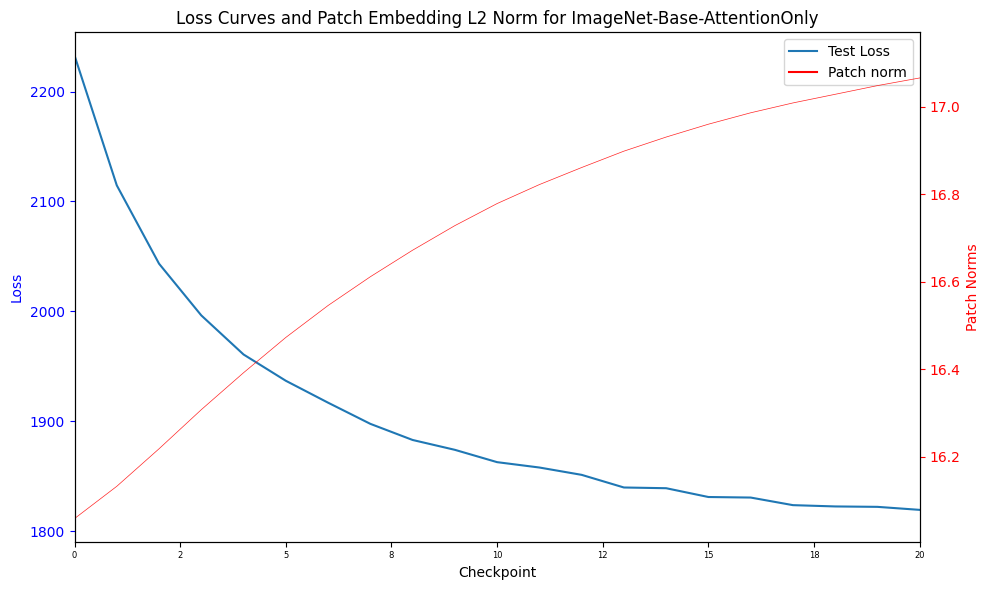

File already exists.


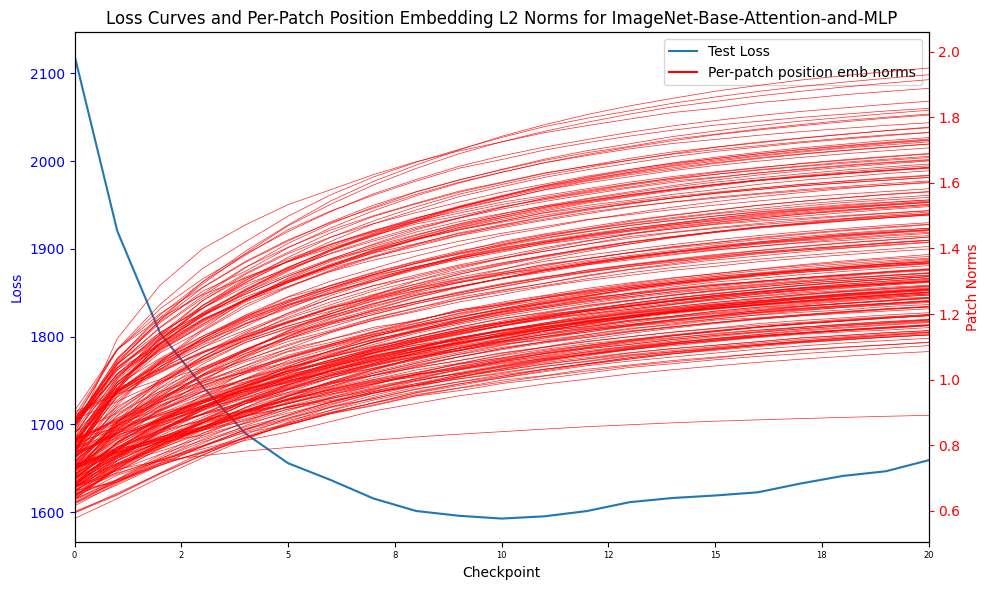

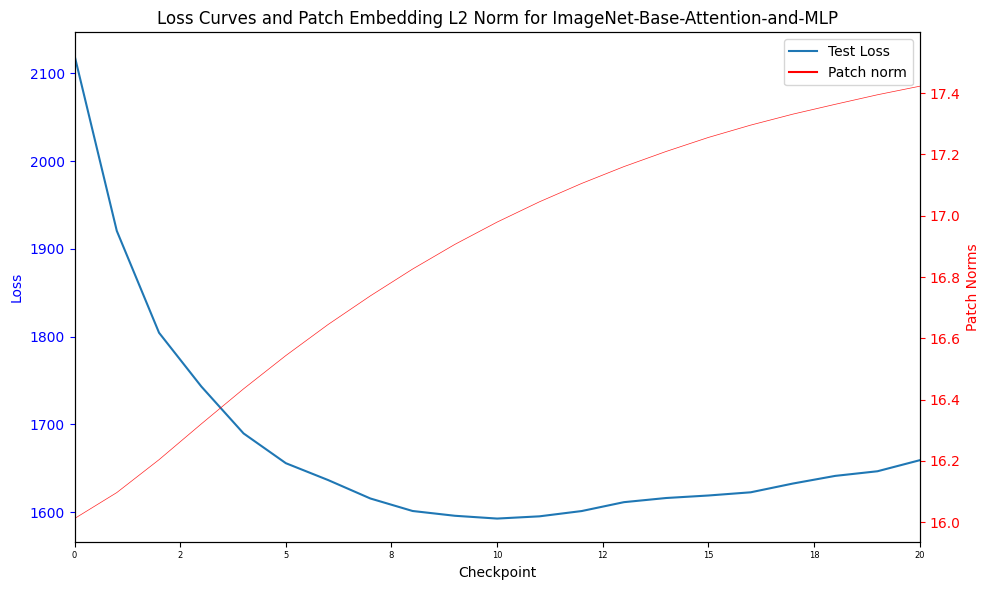

File already exists.


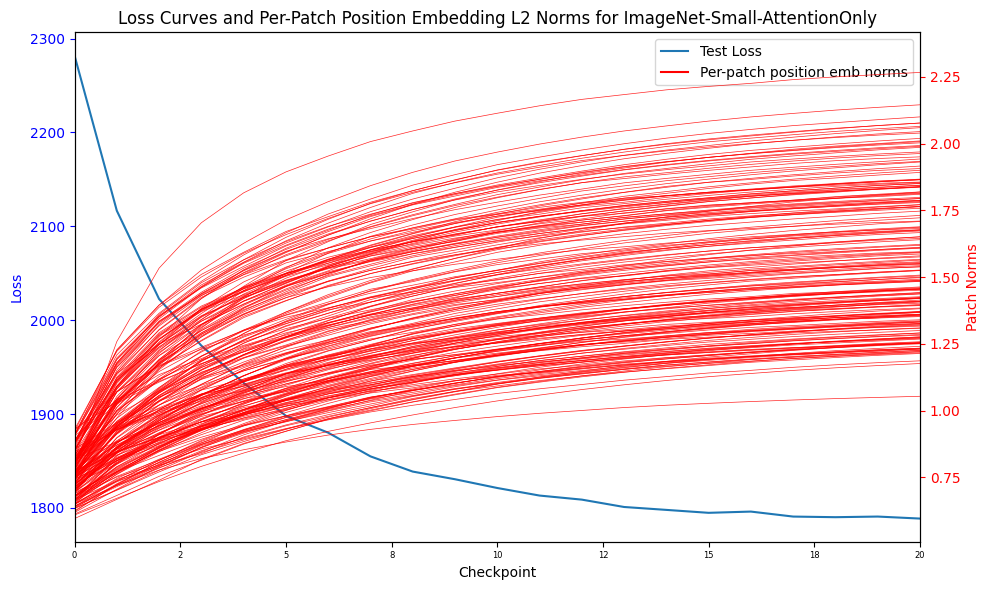

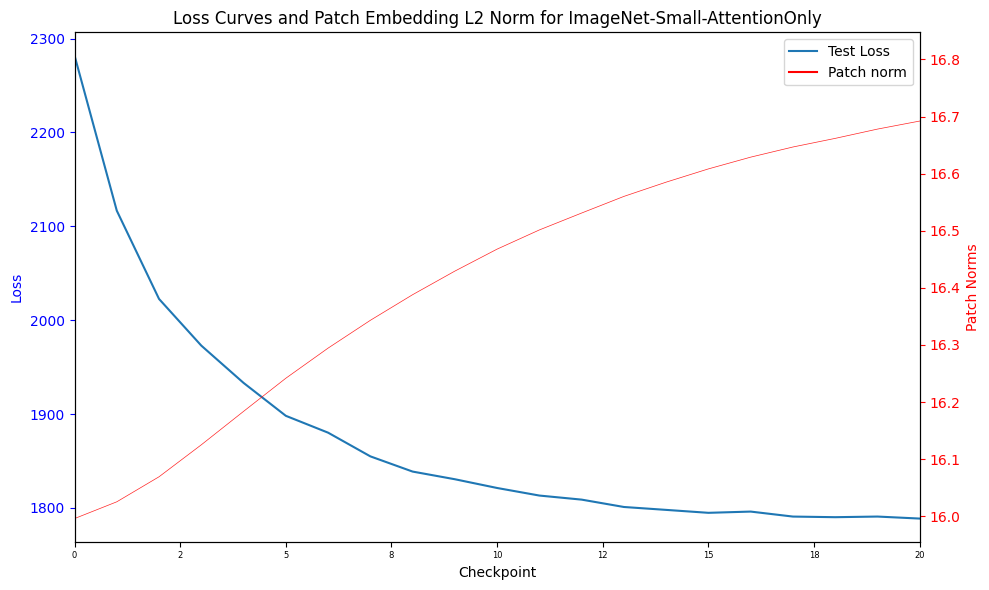

File already exists.


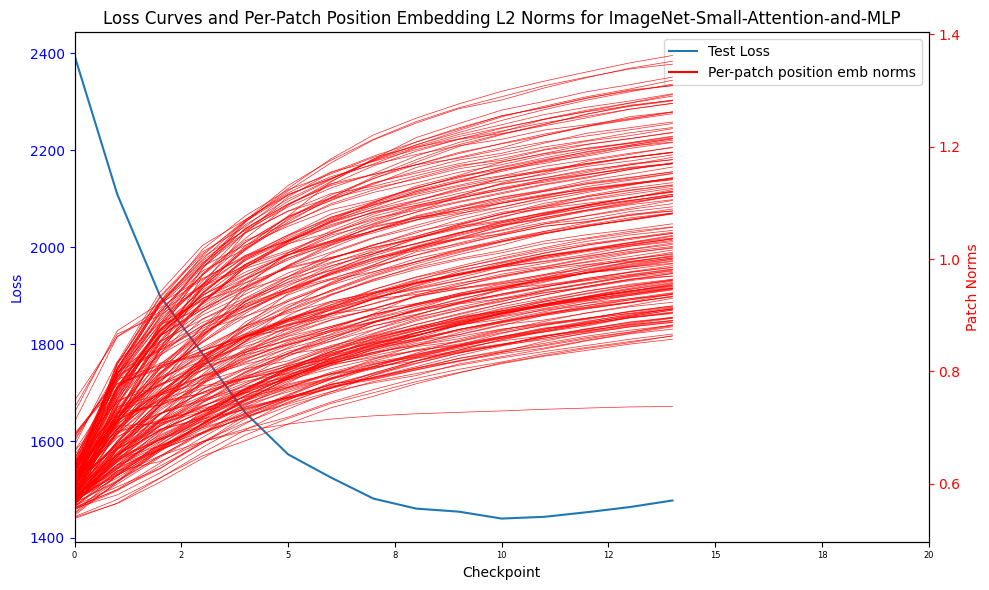

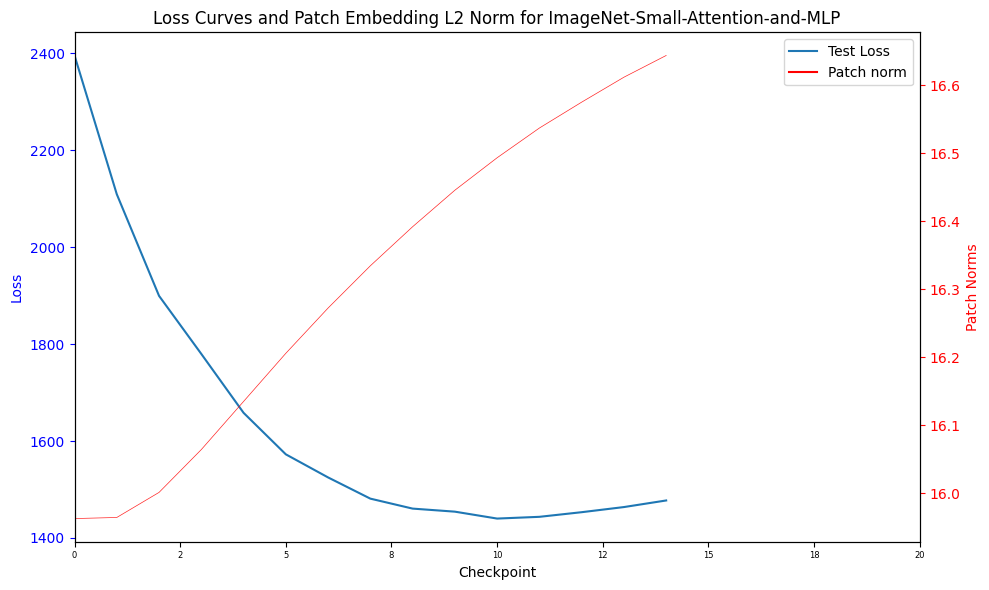

File already exists.


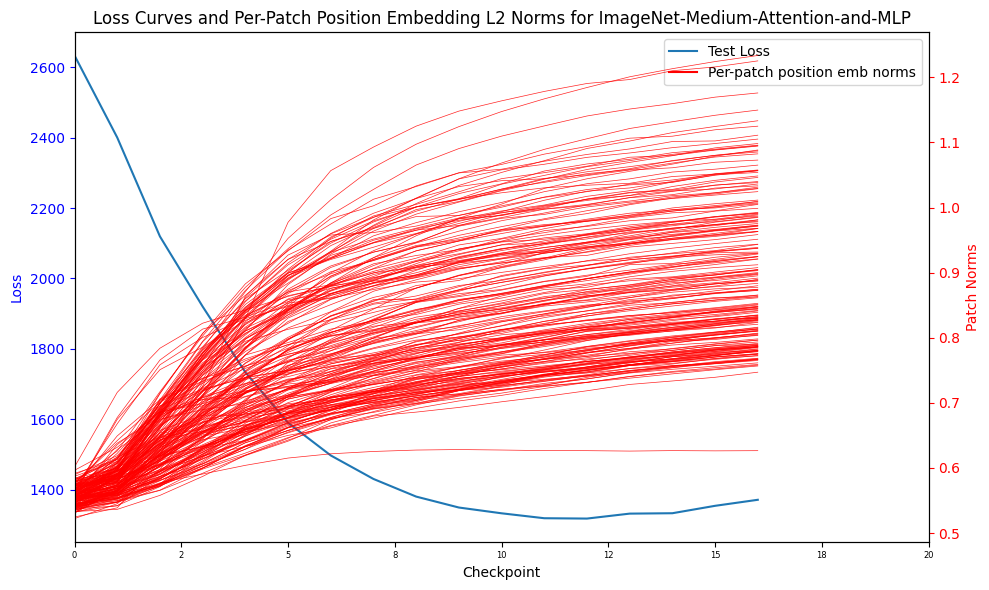

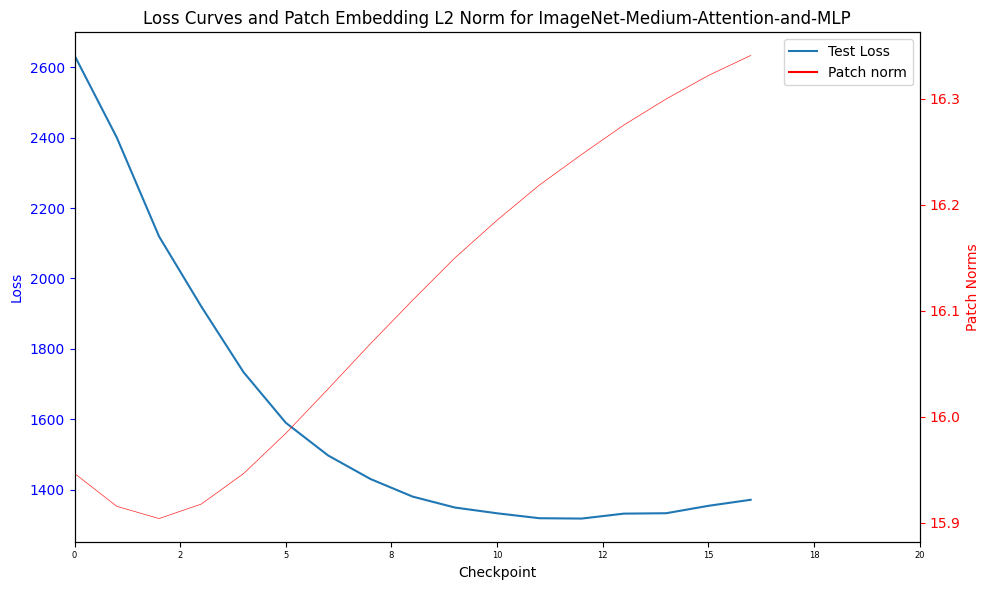

File already exists.


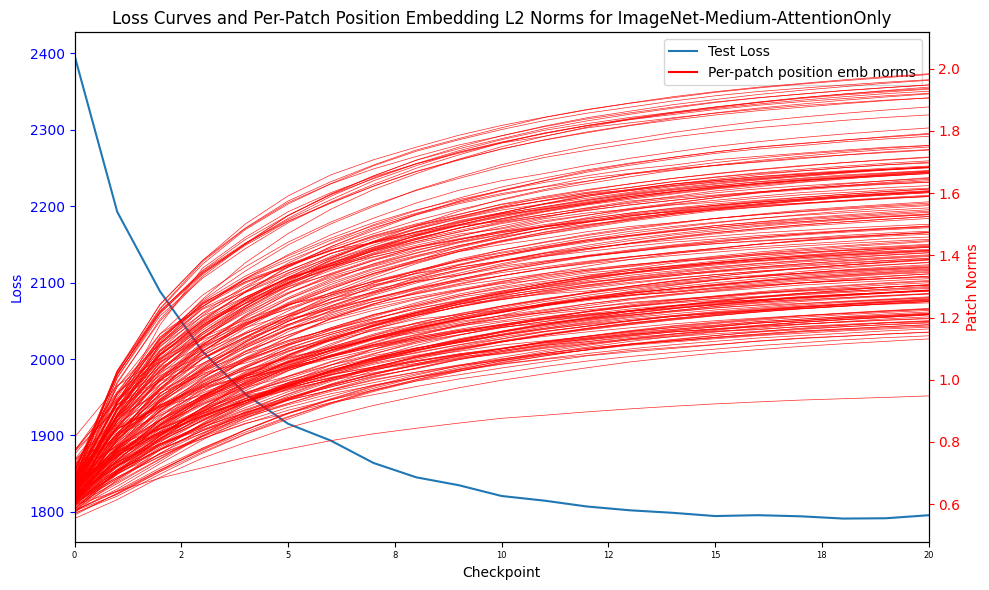

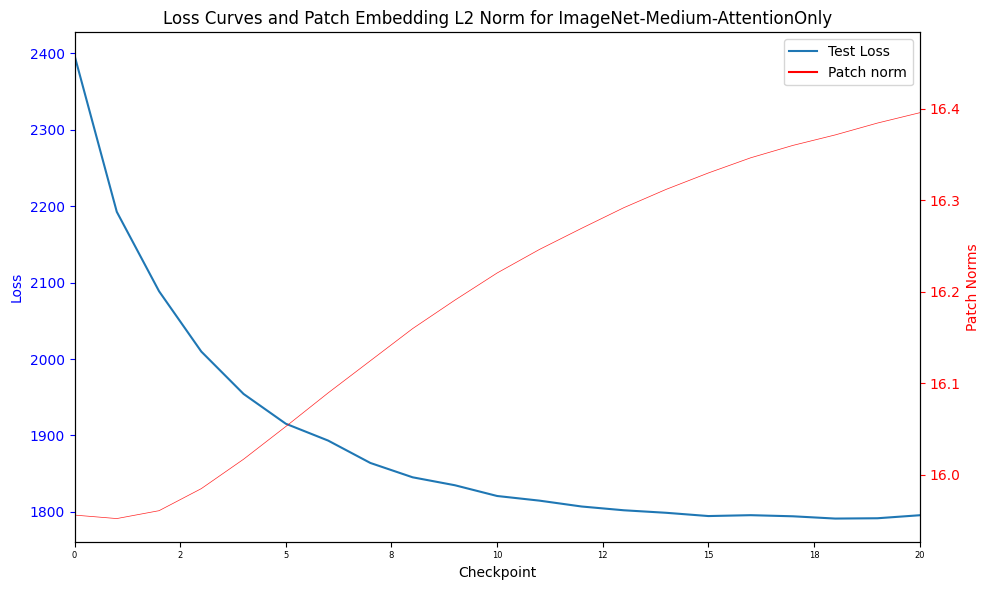

In [226]:
import numpy as np 

def plot_all_weights_for_model(repo_name):
    full_repo_id = f'IamYash/{repo_name}'
    
    _, num_checkpoints = get_checkpoint_info(full_repo_id)

    patch_num = 197
    pos_norms = np.zeros((patch_num, num_checkpoints))
    patch_norms = []

    qkv_weight_norms = []
    qkv_bias_norms = []

    for c in range(num_checkpoints):
        model = load_huggingface_model(c, full_repo_id, TOTAL_DICTIONARY[repo_name]['transformer_config'])

        norms = get_position_embedding_norms(model).numpy()
        pos_norms[:, c] = norms
        
        patch_norms.append(get_patch_embedding_norms(model).detach().numpy())

        # Retrieve and store QKV norms
        q_weight_norms_np, k_weight_norms_np, v_weight_norms_np, q_bias_norms_np, k_bias_norms_np, v_bias_norms_np = get_per_head_qkv_l2_norms(model)
        qkv_weight_norms.append((q_weight_norms_np, k_weight_norms_np, v_weight_norms_np))
        qkv_bias_norms.append((q_bias_norms_np, k_bias_norms_np, v_bias_norms_np))

    # create loss
    create_loss(repo_name, TOTAL_DICTIONARY[repo_name]['run_id'])

    plot_pos(f'loss_curves/{repo_name}.csv', repo_name, pos_norms)
    plot_patch(f'loss_curves/{repo_name}.csv', repo_name, patch_norms)
    
    plotly_patch_with_qkv(f'loss_curves/{repo_name}.csv', repo_name, qkv_weight_norms, qkv_bias_norms)
    plotly_combined_qkv_norms(f'loss_curves/{repo_name}.csv', repo_name, qkv_weight_norms, qkv_bias_norms)

for k in TOTAL_DICTIONARY.keys():
    plot_all_weights_for_model(k)


In [21]:
# Load attention patterns

from vit_prisma.visualization.visualize_attention_js import plot_javascript
from IPython.display import display, HTML



In [2]:
# load model
model = load_huggingface_model(0, 'IamYash/ImageNet-Medium-AttentionOnly', TOTAL_DICTIONARY['ImageNet-Medium-AttentionOnly']['transformer_config'])

NameError: name 'load_huggingface_model' is not defined

In [39]:
# Load imagenet
import json
import numpy as np
import random

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset



# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Load the JSON file into a Python dictionary
with open(json_file_path, 'r') as file:
    num_to_word_dict = json.load(file)

# Create a reverse dictionary for word to number mapping
word_to_num_dict = {}
for num, words in num_to_word_dict.items():
    for word in words:  # Assuming each entry in num_to_word_dict is a list of words
        word_to_num_dict[word] = num

# Function to get the class name from a label
def get_class_name(label):
    # Assuming the label maps to a list of class names
    return num_to_word_dict.get(str(label), ["Unknown label"])[1]

# Function to get the label from a class name
def get_label(class_name):
    return word_to_num_dict.get(class_name, "Unknown class name")

# Get class names
imagenet_class_nums = np.arange(0, 1000, 1)
imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]

# Set the seed. You don't need indices if data is loaded in same order every time.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])



# Function to load images based on saved order
def load_images_in_order(indices_path, imagenet_dataset):
    indices = np.load(indices_path)
    subset_dataset = Subset(imagenet_dataset, indices)
    data_loader = DataLoader(subset_dataset, batch_size=1)
    return data_loader



# Load the ImageNet dataset
batch_size = 1
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)


# Create 500 random samples from the ImageNet dataset
num_samples = 500
random_indices = np.random.choice(len(imagenet_data), num_samples, replace=False)

# Save the order of these indices
np.save('imagenet_sample_indices.npy', random_indices)

data_loader = load_images_in_order('imagenet_sample_indices.npy', imagenet_data)

In [40]:
from vit_prisma.utils.get_activations import get_activations

# Get all attention patterns across test dataset
total_activations = []
for idx, block in enumerate(model.blocks):
    print("On block {}".format(idx))
    activations = get_activations(model, model.blocks[idx].attention.qkv, data_loader, use_cuda=True)
    total_activations.append(activations)

print("Shape of activations per layer: {}".format(activations.shape))

On block 0


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:01<?, ?it/s]


On block 1


  0%|          | 0/500 [00:00<?, ?it/s]


On block 2


  0%|          | 0/500 [00:00<?, ?it/s]


On block 3


  0%|          | 0/500 [00:00<?, ?it/s]

Shape of activations per layer: (1, 197, 768)


In [1]:
activations[0def get_activations(net,layer,data_loader,use_cuda=True, max_count=0, test_run=False, debug=True):
    '''
    Get activations of a layer for a given data_loader
    '''
    activations = []
    def hook_fn(m,i,o):
        activations.append(i[0].cpu().numpy())
    handle = layer.register_forward_hook(hook_fn)
    if use_cuda:
        net = net.cuda()
    net.eval()
    for i, (images, labels) in enumerate(tqdm(data_loader)):
        if debug: print(i)
        if use_cuda:
            images = images.cuda()
        with torch.no_grad():
            output = net(images)
    handle.remove()
    activations_np = np.vstack(activations)     # assuming first dimension is num_examples: batches x batch_size x <feat_dims> --> num_examples x <feat_dims>
    return activations_np


class ActivationCacheHook:
    '''
    Hook to save activations of a layer
    '''
    def __init__(self):
        self.activations = []

    def __call__(self, module, input, output):
        self.activations.append(output.clone())

class CustomAttention(nn.Module):
    '''
    Custom attention layer
    '''

    def __init__(
            self,
            dim,
            num_heads=8,
            qkv_bias=False,
            qk_norm=False,
            attn_drop=0.,
            proj_drop=0.,
            norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.q_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
        self.k_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.attn_scores = nn.Identity()
        self.attn_pattern = nn.Identity()  # Initialize attn_pattern


    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        q, k = self.q_norm(q), self.k_norm(k)

        q = q * self.scale

        attn_scores = q @ k.transpose(-2, -1)
        attn_scores = self.attn_scores(attn_scores)

        attn_pattern = attn_scores.softmax(dim=-1)
        attn_pattern = self.attn_pattern(attn_pattern) # For hook function

        attn = self.attn_drop(attn_pattern)

        x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return xshape

SyntaxError: invalid syntax (4266662431.py, line 1)